This notebook is by Anastasia Ruzmaikina.

In this notebook, I use the backtest program written by Senbagaraman Sudarsanam to test out a very low risk trading strategy 'lowvol2'.

The strategy 'lowvol2' is written by me. 

This is a long only strategy, i.e. it concentrates on predicting which stocks are going up in price on the next time step (those stocks would have positive log returns) and is buying only those stocks. In fact, as required by the backtest, only top 5 (or another specified number such as top 3) best stocks are bought at each time step.
The goal of the strategy is to make an accurate prediction of the most promising stocks to buy for the next time step or if such prediction is deemed impossible, to find conditions under which to "sit out" that time step.

The criteria applied to the stocks to pick out the "promising" stocks have to do with the linear combination of moving averages with different size windows, the linear combination of the exponentially weighted moving averages with different size windows, predictions made by the polynomial linear regression, performance of the stock on the previous time steps, and other criteria applied to the individual stocks.

The stocks which perform well according to all of these criteria are added to the array "sig" of recommended stocks, with the weight equal to the score attached to each stock (the heigher the weight, the more promising is the stock).

It turns out that sometimes the criteria listed above fail to predict the performance of the stock at the next time step. I noticed that this usually occurs in the 'high volatility regions'. To separate out the 'high volatility regions' I calculate several indicators having to do with the first, second and third discrete derivatives of second and third moments of log returns of the individual stocks as well as of the averages over all of the stocks.
I then drop the stocks which have a high 'volatility score' from the array of recommended stocks "sig", assigning them weight zero instead.

The backtesting program picks only top 5 (or another specified number such as 3) of the stocks with the heighest weights (where weights are normalized to add up to 1) to trade at each time step. 

I noticed that the strategy 'lowvol2' is very cautious and very low risk. The backtest results show that the strategy does not lose money, but has periods of time when it stops trading. The results of the backtest show that depending on the values of the parameters, the strategy earns on average about 82% to 98% increase in the cumulative PnL percentage of the portfolio per year. The interesting thing about the strategy is that it does not follow individual stocks, so it is completely automated once the parameters have been tuned.

For optimal results, the parameters of the strategy should be 'tuned' every few weeks.

First, we download the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
import seaborn as sns
import heapq
import psycopg2
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, ETS
import statsmodels.api as sm
from scipy.stats import moment

Before we start, let us take a look at the kind of data we are going to be studying. 

Here is the dataset of log returns of one of the stocks for the time period from 5/23/2018 to 5/23/2023.

In [2]:
data = pd.read_csv('Stock1.csv')
data

,log_returns
0,-0.009987
1,0.005408
2,-0.032775
3,-0.013849
4,-0.032129
...,...
1158,-0.039066
1159,0.012543
1160,-0.039570
1161,0.009037


From the descriptive statistics, we can see that the mean of the log returns is about $0$, the standard deviation is about $0.03$ and occasionally the log returns take large values, since the maximum is about $0.13$ and the minimum is about $-0.28$.

In [3]:
data.describe()

,log_returns
count,1163.000000
mean,-0.000314
std,0.028609
min,-0.282236
25%,-0.014755
50%,0.000938
75%,0.013948
max,0.131991


From the graph of the log returns, we see that they display oscillatory behavior, with the sign changing from positive to negative very often. From the first glance, the behavior looks random.

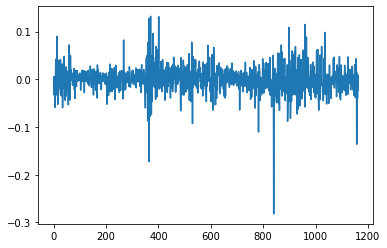

In [4]:
plt.plot(data)

In what follows we shall download the stock data for the past several years (number of years is specified by the variable YRS), we are going to need the last endpoint of the stock history specified in the datetime format (Y,M,D).

Therefore all of the 'closing' stock prices for each stock are downloaded for the time period from TODAY - YRS to (Y,M,D). We are going to specify particular values for those variables right now.

In [9]:
YRS = 3   # number of years of stock price history from today's date
Y = 2023  # year of the rhs of the time interval
M = 5     # month of the rhs of the time interval
D = 23    # day of the rhs of the time interval

Here I load the backtesting program which I got from its author Senbagaraman Sudarsanam. 

The backtesting program first defines 23 different helper functions which are used. Then it downloads the stock price data from 43 specified stocks such as Tesla, Etsy, Uber, etc. The stock data over a specified period of time are downloaded, in this case the period of time is either 10/18/2020 to 5/23/2023, or 10/18/2019 to 5/23/2023. After the stock data is downloaded the stock prices are converted into log returns $ ln(S_t/S_{t-1})$, which are used as inputs into any trading strategy.

The trading strategy (written by me and explained later) is loaded into the backtest function together with the log returns. The strategy specifies which stocks are to be traded at any particular day. The backtest function adds up the PnL percentages. 

The display_backtest function takes the array of the PnL percentages (divided by 100, i.e. $(\frac{S_t}{S_{t-1}}-1)$)  as a function of time, plots them as a cumulative PnL percentage for the portfolio as a function of time and calculates the Sharpe ratio, the Sortino ratio and the percentage of winning days. It displays the mean PnL percentage graph stock by stock and a heat map of cumulative PnL percentage as a function of time for each stock.

In [10]:
#Defining Some Utility functions

def klargest(nums, k): #this function return k largest elements of an array in descending order
    h = []
    for e in nums:
        heapq.heappush(h, (-e, e)) #push an element (-e, e) into existing min heap h such that heap property is maintained
    klarg=[]           #h example   h = [(1, -1), (1, -1), (2, -2), (2, -2), (4, -4), (5, -5)]
    for i in range(k):
        w, e = heapq.heappop(h) #removes the smallest element of the heap, example w=1, e=-1
        klarg.append(e)
    return np.asarray(klarg)
def trunc_sig(signals,trades=5): #returns specified (default 5) number of signals with the largest absolute values
    klargabs=klargest(abs(signals),trades)
    out=[]
    for i in range(len(signals)):
        if abs(signals[i]) in klargabs:
            out.append(signals[i])
        else:
            out.append(0)
    return [np.asarray(out)[i] for i in range(len(out))]

#Truncating Signals,Long Only
def trunc_siglo(signals,trades=5): #chooses specified (default 5) number of signals with largest values
    klarg=klargest(signals,trades)
    out=[]
    for i in range(len(signals)):
        if signals[i] in klarg and signals[i]>0:
            out.append(signals[i])
        else:
            out.append(0)
    return [np.asarray(out)[i] for i in range(len(out))]

#Load Data from our Database
#Tickers
def get_universe_tickers(universe_id, exchange='us_equity',exclude_tickers=[]):
    meme_tickers = ['GME', 'AMC', 'FSLY', 'BABA', 'FNGU', 'JD', 'SQQQ', 'TQQQ', 'SQ', 'TSLA']
    if exclude_tickers:
        mem_tickers=mem_tickers+exclude_tickers
    where_condition = ""
    if universe_id:
        where_condition = f"universe_id= '{universe_id}'"
    else:
        return print('please provide universe_id')
    if exchange:
        where_condition += f" AND exchange='{exchange}'"
    conn = psycopg2.connect(database="snowball", user="snowball", password="snowball",host="snowball.cjnnpjaznzb8.us-east-1.rds.amazonaws.com", port="5432")
    cur = conn.cursor()
    cur.execute(f"SELECT included_items, excluded_items, non_shortable_items FROM algos_universetype WHERE {where_condition}")
    universe = cur.fetchall()
    final = []
    tickers_non_shortable = []
    if universe:
        tickers_to_include = list(eval(str(universe[0][0])))
        tickers_to_exclude = universe[0][1]
        tickers_non_shortable = universe[0][2]
        if tickers_to_exclude:
            tickers_to_exclude = list(eval(str(tickers_to_exclude)))
        else:
            tickers_to_exclude = []
        if tickers_non_shortable:
            tickers_non_shortable = list(eval(str(tickers_non_shortable)))
        final = [ticker_to_include for ticker_to_include in tickers_to_include if ticker_to_include.strip(" ") not in [ticker_to_exclude.strip(" ") for ticker_to_exclude in tickers_to_exclude]]
        final = list(set(final)-set(meme_tickers))
    return final, tickers_non_shortable
#final:['QQQ', 'CHWY', 'KSS', 'MRNA', 'PLUG', 'QCOM', 'CVX', 'SBUX',
      # 'AAPL', 'XOP', 'VLO', 'WDC', 'PDD', 'XBI', 'SNAP', 'TSM', 'UBER',
      # 'NET', 'XLK', 'NVDA', 'IBM', 'DIS', 'ETSY', 'JPM', 'LYFT', 'IBB',
      # 'MPC', 'AMAT', 'COF', 'SPY', 'MSFT', 'BRK.B', 'BA', 'MU', 'MA',
      # 'AXP', 'CZR', 'JNJ', 'IWM', 'ROKU', 'PYPL', 'ABBV', 'V']
#tickers_to_include:['TSLA', 'ROKU', 'MRNA', 'PDD', 'NVDA', 'ETSY', 'FB', 'SQ', 'BA',
      # 'DIS', 'PLUG', 'IWM', 'XBI', 'MSFT', 'QQQ', 'AAPL', 'PYPL', 'SPY',
      # 'TSM', 'CHWY', 'JPM', 'AMAT', 'XOP', 'SNAP', 'QCOM', 'NET', 'IBB',
      # 'MU', 'AXP', 'CVX', 'V', 'BRK.B', 'UBER', 'ABBV', 'TWTR', 'LYFT',
      # 'KSS', 'CZR', 'MPC', 'XLK', 'SBUX', 'COF', 'VLO', 'JNJ', 'MA',
      # 'WDC', 'IBM']
      
#OHLCV given tickers
def get_ohlcv_from_db_raw(tickers, start=datetime(2016,11,25), end=datetime.now(), span='day'):
    where_condition = ""
    if span == 'minute':
        datetime_format = '%Y-%m-%d %H:%M'
        table_from = "algos_ohlcv_1min"
    elif span == 'hour':
        datetime_format = '%Y-%m-%d %H'
        table_from = "algos_ohlcv_1hour"
    else:
        datetime_format = '%Y-%m-%d'
        table_from = "algos_ohlcv_1day"
    if type(start) != str:
        start_datetime = start.strftime(datetime_format)
    else:
        start_datetime = start
    if type(end) != str:
        end_datetime = end.strftime(datetime_format)
    else:
        end_datetime = end
    where_condition += f" tdate >= '{start_datetime}' AND tdate <= '{end_datetime}'"
    conn = psycopg2.connect(database="snowball", user="snowball", password="snowball",host="snowball.cjnnpjaznzb8.us-east-1.rds.amazonaws.com", port="5432")
    outdf = []
    for ticker in tickers:
        raw_query = f"SELECT tdate, topen, thigh, tlow, tclose, tvolume, tvwap FROM {table_from} AS tb join algos_instrument AS i ON i.id = tb.tradingsymbol_id WHERE i.tradingsymbol = '{ticker}' AND {where_condition}"
        df = pd.read_sql_query(raw_query, conn)
        if not df.empty:
            df = df.rename(columns={"tdate": "Date", "topen": "Open", "thigh": "High", "tlow": "Low", "tclose": "Close", "tvolume": "Volume", "tvwap": "Vwap"})
            df['Date'] = df['Date'].dt.tz_convert('America/New_York')
            df.sort_values(by='Date', inplace=True)
            df.reset_index(drop=True, inplace=True)
        else:
            df = pd.DataFrame()
        outdf.append(df)
    return outdf

def listnannum(lst):  #replaces inf with a large number, nan with 0
    return np.asarray([np.nan_to_num(a) for a in lst])

#Some Mathematica Functions!

def di(a): #returns one step differences
     return np.asarray([a[i+1]-a[i] for i in range(len(a)-1)])
    
def accumulate(a): #returns the running sum of the array up to the current index
    out=[a[0]]
    for i in range(1,len(a)):
        out.append(out[i-1]+a[i])
    return np.asarray(out)

def listsum(vecs): #returns column sum of a matrix
    out=np.asarray(vecs[0])
    for i in range(1,len(vecs)):
        out=out+np.asarray(vecs[i])
    return np.asarray(out)

def listmean(a): #returns list of means of each row of a matrix
    return np.asarray([np.mean(a[i]) for i in range(len(a))])


def listmeanC(a, C): #returns list of means of each row of a matrix
    return np.asarray([max(np.mean(a[i])-C,0) for i in range(len(a))])

def listmeanlowC(a, C): #returns list of means of each row of a matrix
    return np.asarray([min(np.mean(a[i])-C,0) for i in range(len(a))])


def listmeanexpC(a, C): #returns list of means of each row of a matrix
    b = a
    for i in range(len(b)):
        b[i] = a[i]*(2**((len(b)-1-i)/30))
    return np.asarray([max(np.mean(b[i])-C,0) for i in range(len(a))])


def listaccumulate(lst): #returns cumulative sum of each row of a matrix up to a current index
    return np.asarray([accumulate(lst[i]) for i in range(len(lst))])

def listaccumulateC(lst, C): #returns cumulative sum of each row of a matrix up to a current index
    carray = np.asarray([np.array(accumulate(lst[i])-C) for i in range(len(lst))])
    out = np.zeros((len(carray), len(carray[0])))
    for i in range(len(carray)):
        for j in range(len(carray[0,:])):
            if carray[i,j]>0.00000001*i:
                out[i,j]=carray[i,j]
    return np.asarray(out)

def cumulativesum(A):
    arr = [[]]*len(A[:,0])
    for i in range(len(A[:,0])):
        sum = 0
        arr[i] = []
        for j in range(len(A[0,:])):
            sum += A[i,j]
            arr[i].append(sum )
    arr = np.array(arr)
    return arr

#Helper Functions for calculating Performance Statistics
def sharpe(a): #returns Sharpe ratio for an array
    return np.mean(a)/np.std(a)

def semidev(a): #if mean is positive, returns stdev of negative part of array, if mean negative, returns stdev of positive part of array
    pos=[]
    neg=[]
    for x in a:
        if x<0:
            neg.append(x)
        if x>=0:
            pos.append(x)
    if np.mean(a)>=0:
        return np.std(neg)
    if np.mean(a)<0:
        return np.std(pos)
def sortino(a): #returns sortino ratio of expected return divided by stdev of negative asset returns
    if np.mean(a)!=0 and semidev(a)!=0:
        a2=np.mean(a)/semidev(a)
    else:
        a2=0
    return a2
    
def ic2(a):#returns the ratio of a number of positive elements to total number of elements in an array
    pos=len([i for i in a if i>=0])
    neg=len([i for i in a if i<=0])
    return (pos)/(pos+neg)

def perfstats(pnl,frequency="daily"): #profit to loss ratio, ret is cumulative sum
    ret=np.sum(pnl)
    sharp=sharpe(pnl)*np.sqrt(len(pnl))
    sort=sortino(pnl)*np.sqrt(len(pnl))
    percwinning=ic2(pnl)
    print("The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days")
    return ret,sharp,sort,percwinning

def perfstatsdi(a): #returns performance statistics for one step differences
    return perfstats(di(a))
    
####### load data
#Load Tickers from our predefined universes, 1.1, 2.1,3.1
#Get a list of OHLCV dataframes to pass into logrets above
tickers_univ1p1=(get_universe_tickers('1.1', exchange='us_equity')[0])
ohlcv_data1p1=get_ohlcv_from_db_raw(tickers_univ1p1,datetime.now()-relativedelta(years=YRS), datetime(Y,M,D))
tickers_univ2p1=(get_universe_tickers('2.1', exchange='us_equity')[0])
ohlcv_data2p1=get_ohlcv_from_db_raw(tickers_univ2p1,datetime.now()-relativedelta(years=5), datetime(2023,4,30))
tickers_univ3p1=(get_universe_tickers('3.1', exchange='us_equity')[0])
ohlcv_data3p1=get_ohlcv_from_db_raw(tickers_univ3p1,datetime.now()-relativedelta(years=5), datetime(2023,4,30))


####################################
# Calculate and store the Daily Log Returns as a 2d array
def logrets(ohlcv_data):
    """
    Input: OHLCV list of dfs
    Output: 2-d array of Log Returns [logret(stock1),...logret(stock k)]
    """
    sectalpha1=[]
    for i in range(len(ohlcv_data)): #calculates log of ratio of returns at Close on ith day to Close on i-1st day
        sectalpha1.append(np.log(ohlcv_data[i]['Close']/ohlcv_data[i]['Close'].shift(1)))
    return listnannum(sectalpha1)

######## log returns
x = len(logrets(ohlcv_data1p1)[0])
lrs = np.empty(shape=(0,0))
for i in range(43):
    #for j in range(len(logrets(ohlcv_data1p1)[i])):
        lrs = np.append(lrs,(logrets(ohlcv_data1p1)[i]))
lrs = np.reshape(lrs[:], (43,x))

####################################
#Load the Backtester
#This is a basic fast backtester (without transaction costs)
#It is ideal for EDA
#Backtester
def backtest(lrs, foo, params,binmem=False,alphas=[]):#foo is prediction_function
    #print(len(lrs))
    kwargs = params     #what parameters are used? {'longonly':0, 'trades':5,'lb':20,'lf':1,'test_years':1, ...}
    #kwargs2 has the same params but all trades
    kwargs2 = params.copy()
    kwargs2['trades']=len(lrs)-1
    trades = 3
    longonly=1 #0
    price_type = 'Close'
    capital = 1
    lb = 20
    lf = 1
    back_test_years = 1
    compounding = False
    frequency_type = 'close to open'
    earnings=[]
    dmn=False
    if 'longonly' in kwargs.keys():
        longonly = kwargs['longonly']
    if 'trades' in kwargs.keys():
        trades = kwargs['trades']
    if 'lb' in kwargs.keys():
        lb = kwargs['lb']
    if 'tot_capital' in kwargs.keys():
        capital = kwargs['tot_capital']
    if 'lf' in kwargs.keys():
        lf = kwargs['lf']
    if 'test_years' in kwargs.keys():
        back_test_years = kwargs['test_years']
    if 'compounding' in kwargs.keys():
        compounding = True
    if 'frequency_type' in kwargs.keys():
        frequency_type = kwargs['frequency_type']
    if 'earnings' in kwargs.keys():
        earnings = kwargs['earnings']
    if 'dmn' in kwargs.keys():
        dmn = kwargs['dmn']
    out=[]
    perclist_list = []
    for i in range(lb,len(lrs[0])):
        if len(earnings):
            if len(alphas)==0: #foo is the trading strategy called prediction_function(json, lrs,longonly=False,other_inputs=[])
                perclist_totfinal = foo(kwargs2, lrs[:,i-lb:i])*earnings[:,i-1] #predictions for each stock window in time from i-lb to i
                
            else:
                perclist_totfinal = foo(kwargs2, lrs[:,i-lb:i],alphas[:,i-lb:i])*earnings[:,i-1] 
                
            if longonly==0:
                perclist_totfinal=np.asarray(trunc_sig(perclist_totfinal,trades)) #only keep 5 stocks with largest absolute value
            elif longonly==1:
                perclist_totfinal=np.asarray(trunc_siglo(perclist_totfinal,trades)) #only keep 5 stocks with largest value
            elif longonly==2:
                perclist_totfinal=np.asarray(trunc_sigso(perclist_totfinal,trades))
            elif longonly==3:
                perclist_totfinal=np.asarray(trunc_sigls2(perclist_totfinal,trades))
            if np.sum(abs(perclist_totfinal))>0:
                perclist_totfinal=perclist_totfinal/np.sum(abs(perclist_totfinal)) #normalize
            else:
                perclist_totfinal=np.zeros(len(perclist_totfinal)) #where is an actual trade
        else:
            if len(alphas)==0:#foo is prediction_function(json, lrs,longonly=False,other_inputs=[])
                perclist_totfinal = foo(kwargs, lrs[:,i-lb:i])
                
            else:
                perclist_totfinal = foo(kwargs, lrs[:,i-lb:i],alphas[:,i-lb:i])
                
        if lf > 1:
            perclist_list.append(perclist_totfinal)
            perclist_totfinal2 = listsum(perclist_list[-lf:]) / lf
        else:
            perclist_totfinal2 = perclist_totfinal

        pred = perclist_totfinal2  #pred are the weigts assigned to each stock
        pred=np.nan_to_num(pred/np.sum(abs(pred)),0)   #replace NaN with 0, infinity with a large number
        y=lrs[:,i]
        if binmem:
            y=np.sign(y)
        out.append(np.multiply(pred,np.e**(y)-1))
    outt=np.transpose(out)
    return outt,accumulate(listsum(outt)),listmean(outt)


def display_backtest(logrets,mainfunc,params,binmem=False,alphas=[]):
    """
    Inputs:
    1. logrets (2-d array): log returns
    2. mainfunc (function): your prediction function
    3. params (dictionary): parameters of your model 
    Prints:
    Backtest Results
    """
    aa,bb,cc=backtest(logrets, mainfunc, params=params,binmem=False,alphas=alphas)
    print("Returns, Sharpe, Sortino, Perc Winning Days",perfstatsdi(bb))
    print("Equity Curve(PNL on $1)")
    plt.plot(bb)
    plt.show()
    print("Stock Wise PNL Visualisation")
    plt.plot(cc)
    plt.show()
    print("Time wise and Stock wise PNL heatmap")
    sns.heatmap(listaccumulate(aa))
    nn = np.array(backtest(logrets, mainfunc, params=params,binmem=False,alphas=alphas))
    

Before we go further we can take a look at the 43 stocks we downloaded. Here is the plot of the log returns for each stock as the function of time, for the time interval from 10/20/2023 to 5/23/2023:

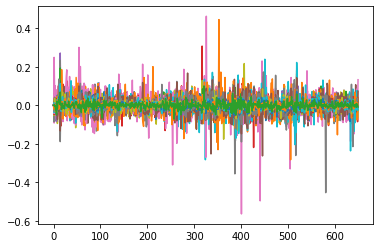

In [21]:
for i in range(43):
    plt.plot(lrs[i,:])
    #plt.plot(logrets(ohlcv_data1p1)[i][:])   #same as lrs

It can be seen from the graph that the behavior of log returns for each stock is highly oscillatory with the mean around zero, low standard deviation and occasional large deviations from the mean.

We are now ready to construct a trading strategy for those stocks.

The prediction_function is a shell compatible with the backtest function. It contains trading strategies, specified by the line 'if strategy_id == ...'. 

It takes the matrix of log returns for each stock as input and returns the normalized weights of the stocks which are to be traded (as an array "sig" with 43 elements which are either zero if the stock is not traded or positive if the stock is traded) as output.

The strategy 'lowvol2' is written by me. 

This is a long only strategy, i.e. it concentrates on predicting which stocks are going up in price on the next time step (those stocks would have positive log returns) and is buying only those stocks. In fact, as required by the backtest, only top 5 (or another specified number such as top 3) best stocks are bought at each time step.
The goal of the strategy is to make an accurate prediction of the most promising stocks to buy for the next time step or if such prediction is deemed impossible, to find conditions under which to "sit out" that time step.

The criteria applied to the stocks to pick out the "promising" stocks have to do with the linear combination of moving averages with different size windows, the linear combination of the exponentially weighted moving averages with different size windows, predictions made by the polynomial linear regression, performance of the stock on the previous time steps, and other criteria applied to the individual stocks.

The stocks which perform well according to all of these criteria are added to the array "sig" of recommended stocks, with the weight equal to the score attached to each stock (the heigher the weight, the more promising is the stock). If the stock is not recommended, it has weight zero in the array "sig".

It turns out that sometimes the criteria listed above fail to predict the performance of the stock at the next time step. I noticed that this usually occurs in the 'high volatility regions'. To separate out the 'high volatility regions' I calculate several indicators having to do with the discrete first, second and third derivatives of second and third moments of log returns of the individual stocks as well as of the averages over all of the stocks.
I then drop the stocks which have a high 'volatility score' from the array of recommended stocks "sig", assigning them weight zero instead.

The backtesting program picks only top 5 (or another specified number such as 3) of the stocks with the heighest weights (where weights are normalized to add up to 1) to trade at each time step. 

I noticed that the strategy 'lowvol2' is very cautious and very low risk. The backtest results show that the strategy does not lose money, but has periods of time when it stops trading. 


In [7]:
def prediction_function(json, lrs,longonly=True,other_inputs=[]): 
    #gives predictions for a given strategy, takes array of log returns as input
    # returns array of normalized weights for each stock which is to be traded as output
    """
    Inputs:
    1. json (dictionary): parameters for your strategy 
    2. lrs (2-d numpy array): log returns
    3. longonly (boolean): long only or long short
    4.other_inputs: other inputs to your model instead of log returns
    Output:
    1.(1-d array) The percentage of capital to be allocated to each stock
    """
    if 'strategy_id' in json.keys():
        strategy_id = json['strategy_id']
    if 'longonly' in json.keys():
        longonly = json['longonly']
    trades=3   #this is the maximum number of stocks to be traded at each time step
    delay=1
    offset=0
    # STRATEGY
    if strategy_id == 'lowvol2':
        # first we fix some of the parameter values used below 
        # (these parameter values need to be 'tuned' every few weeks for optimal performance)
        lb1 = 11 
        lb2 = 22  
        lb3 = 20  
        lb4 = 15  
        lb5 = 18  
        lb21 = 12  
        lb22 = 10  
        le1 = 16   
        le2 = 21   
        le3 = 22  
        le4 = 25  
        degree = 2  
        level = 0.00125 
        level1 = 0.00111 
        level2 = 0.00012 
        level3 = 0.011   
        level4 = 0.002   
        level5 = 0.005   
        level6 = 0.0205 
        p1 = 0.091   
        p2 = 0.38  
        p3 = 0.6    
        q1 = 0.09   
        q2 = 0.045  
        q11 = 0.011 
        q12 = 0.001 
        r1 = 0.007  
        r2 = 0.05   
        r3 = 0.33  
        r4 = 0.03  
        r5 = 0.021 
        
        # the array curr cosists of log returns of all 43 stocks at current time t
        # the array curr1 cosists of log returns of all 43 stocks at previous time t-1
        # the array curr2 cosists of log returns of all 43 stocks at two steps in the past time t-2
        
        curr = np.array(lrs[:,-1])
        curr1 = np.array(lrs[:,-2])
        curr2 = np.array(lrs[:,-3])
        
        # we create an array currexp (over all 43 stocks at a given time step).
        # the array currexp contains a linear combination of exponentially weighted averages with window sizes
        # 16, 21, 22, 24, 25, 26 which represents one of the indicators of a "promising" stock
        # in particular later currexp > 0.00111 is one of the requirements to consider a stock to be traded
        
        currexp = []  #this is for exponential mean
        dfexp = pd.DataFrame(np.array(lrs[:,:]))
        for i in range(len(lrs[:,0])): 
            currexp.append(r1*dfexp.iloc[i,:].ewm(span=le1, adjust=False).mean()
                          +r2*dfexp.iloc[i,:].ewm(span=le2, adjust=False).mean()
                          +r3*dfexp.iloc[i,:].ewm(span=le3, adjust=False).mean()
                           +r4*dfexp.iloc[i,:].ewm(span=24, adjust=False).mean()  
                           +r5*dfexp.iloc[i,:].ewm(span=26, adjust=False).mean()  
                          +(1-r1-r2-r3-r4-r5)*dfexp.iloc[i,:].ewm(span=le4, adjust=False).mean())
        currexp = np.array(currexp)
        
        # in addition to the value of currexp at a current time step t, we are going to make requirements on the 
        # values of the currexp ot the prevous two time steps t-1 and t-2 stored in arrays currexp1 and currexp2
        currexp2 = currexp[:,-3]
        currexp1 = currexp[:,-2]
        currexp = currexp[:,-1]
        
        #using one of the standard functions listmeanC defined as a part of the backtest, 
        #(listmeanC returns list of means of each row of a matrix but only for the entries with values above C),
        # we construct an array rnnm of linear combinations of running means with window sizes 10, 12, 15, 18, 20
        # of log returns of each stock where the stock is taking values above 0.00111
        # array rnnm is at time step t, array rnnm1 is at time step t-1, array rnnm2 is at time step t-2
        rnnm=q1* listmeanC(lrs[:,-lb2:], level1)+q11* listmeanC(lrs[:,-lb21:], level1)+q12* listmeanC(lrs[:,-lb22:], level1)+ q2* listmeanC(lrs[:,-lb5:], level) + (1-q1-q2)* listmeanC(lrs[:,-lb4:], level) #this is for running mean
        rnnm1=q1* listmeanC(lrs[:,-lb2:-1], level1)+q11* listmeanC(lrs[:,-lb21:-1], level1)+q12* listmeanC(lrs[:,-lb22:-1], level1)+ q2* listmeanC(lrs[:,-lb5:-1], level) + (1-q1-q2)* listmeanC(lrs[:,-lb4:-1], level) #this is for running mean
        rnnm2=q1* listmeanC(lrs[:,-lb2:-2], level1)+q11* listmeanC(lrs[:,-lb21:-2], level1)+q12* listmeanC(lrs[:,-lb22:-2], level1)+ q2* listmeanC(lrs[:,-lb5:-2], level) + (1-q1-q2)* listmeanC(lrs[:,-lb4:-2], level) #this is for running mean
        
        # next we predict the log returns using polynomial regression
        # it turns out the polynomial of degree 2 gives the best predictions
        # we use only 11 points as the input data X for each prediction y
        # we store the predictions in the array linarr
        linarr = [] #this is for polynomail regression
        df = pd.DataFrame(np.array(lrs[:,:]))
        for i in range(len(lrs[:,0])):
            X, y = pd.DataFrame(np.linspace(len(lrs[0,:])-lb1, len(lrs[0,:])-1, len(df.iloc[i,-lb1:]))), df.iloc[i,-lb1:]
    
            poly = PolynomialFeatures(degree = degree)
            X_poly = poly.fit_transform(X)
            poly.fit(X_poly, y)
            regressor = LinearRegression()
            regressor.fit(X_poly, y)
            y_pred = regressor.predict(poly.fit_transform(pd.DataFrame(np.linspace(len(lrs[0,:])-1, len(lrs[0,:]), 1))) )    #print(y_pred, df.iloc[i,-1])
            linarr.append(y_pred)
        currsig = np.array(linarr).flatten()
        
        #in some calculations we need the running cumulative sum of log returns of each stock
        # we store the running sums of all 43 stocks in the matrix arr
        arr = [[]]*len(lrs[:,0])
        for i in range(len(lrs[:,0])): #get the running sum of lrs for each stock, store in array arr
            sum = 0
            arr[i] = []
            for j in range(len(lrs[0,:])):
                sum += lrs[i,j]
                arr[i].append(sum )
        arr = np.array(arr)        
        # we store the exponentially weighted mean with window width 10 in the array arrewm 
        #for stocks that show overall down trend, exponential mean is higher than running sum   

        arrewm = []  
        df = pd.DataFrame(np.array(arr))
        for i in range(len(lrs[:,0])): #get exponential mean for each stock
            arrewm.append(df.iloc[i,:].ewm(span=10, adjust=False).mean())
         
        arrewm = np.array(arrewm)
        
        # similarly, we store the exponentially weighted mean with window width 25 and 15 in the arrays arrew and arrew1 
        #for stocks that show overall down trend, exponential mean is higher than running sum   

        arrew = []  
        arrew1 = []
        len1=25 
        len2=15 
       
        df = pd.DataFrame(np.array(arr))
        for i in range(len(lrs[:,0])): #get exponential mean for each stock
            arrew.append(df.iloc[i,:].ewm(span=len1, adjust=False).mean())
            arrew1.append(df.iloc[i,:].ewm(span=len2, adjust=False).mean())
         
        arrew= np.array(arrew)
        arrew1 = np.array(arrew1)
        
        # now we construct an array arrsig which has 43 elements
        # if the stock is considered "promising" and shoud be traded at the next time step, the 'score' of the stock
        # calculated below is appended to arrsig
        # if the stock is not considered 'promising' at time t, the 'score' of the stock is 0, and 0 is appended to arrsig
        arrsig = []
        #I = []
        lev1 = 0.000118   
        lev2 = 0.00115   
        lev3 = 0.0005   
        lev8 = 0.01  
        lev81 = 0.01631 
        # the 'score' of each stock (saved to arrsig) 
        # is a linear combination of currsig (polynomial regression) as well as
        # currexp (linear combination of exponentially weighted moving averages) and of
        # rnnm (linear combination of moving averages)
        # the stock is considered 'promising' and a non-zero score is saved to arrsig only if the stock
        # passes 12 tests such as: the prediction of polynomial regression is above 0.00125, and
        # the linear combination of exponentially weighted averages is above 0.00111, and
        # the linear combination of moving averages is above 0.00012, and
        # the current value of the log return is above 0.011,
        # and other similar criteria which are more difficult to explain which can be found in the if statement below
        for i in range(len(lrs[:,-1])):
            if  (currsig[i] > level and currexp[i]  > level1 and currexp1[i]+lev2 < currexp[i] and arr[i,-1] +lev8> arrewm[i, -1]
                and rnnm1[i]+lev1<rnnm[i] and arrew[i,-2]+lev1 < arrew[i,-1] and arrew1[i,-2]+lev1 < arrew1[i,-1]  
                and rnnm[i] > level2 and lrs[i, -1] > level3 and arrewm[i,-2] +lev1< arrewm[i,-1] 
                and curr[i]>lev3+curr1[i] and curr[i]>lev81):
                a = p1*currsig[i] + p2*currexp[i]+p3*rnnm[i]
                arrsig.append(a) 
            else:
                arrsig.append(0) 
                
        # the array sig is the input of the backtest software and is set to equal to the array arrsig   
        
        sig=np.array(arrsig)
        
        # in some cases, the above criteria do not give good results in the backtest
        # it is important to isolate those cases and drop those stocks from the array sig by assigning them weight 0
        # I noticed that most often 'bad predictions' come when a stock exhibits high volatility
        # to measure the volatility, I use the discrete derivatives of the log returns
        
        # we define ar_diff to be the matrix of discrete 1st derivatives for each stock 
        ar_diff = [] #high volatility regions is where guessing becomes inaccurate, we need to test for it using array of 1st discrete derivatives
        for i in range(1,len(lrs[0,:])): #record changes in volatility (measured by discrete 1st derivative) for all the stocks
            ar_diff.append(np.array(listsum(lrs[:,:i])).std() - np.array(listsum(lrs[:,:i-1])).std()) #listsum returns list of means of each row of a matrix
        
        # the criterion from dropping the stock from array of 'predictions' sig, is that the 1st discrete derivative
        # recorded at time t is above 0.005 and the log returns at t-1, t-2, t-3 are below -0.002
        
        for i in range(len(lrs[:,0])): #remove stocks in high volatility region that show a down trend
            if ar_diff[-1] > level5  and lrs[i,-2] < -level4 and lrs[i,-3] < -level4 and lrs[i,-4] < -level4: #and lrs[i,-5] < level4:
                sig[i] = 0    #removing those stocks has a small effect, increases profit by 0.003, sharpe ratio by 0.03
        
        # next we calculate discrete 1st derivatives of the standard deviation 
        # of the cumulative sum of log returns for each stock and store in array a_diff
        
        a_diff = []
        
        for i in range(len(lrs[:,0])):
    
            a_diff.append(np.array(cumulativesum(lrs)[i][:]).std()-np.array(cumulativesum(lrs)[i][:-1]).std())
            
        # remove stocks from the 'prediction' array sig for which discrete 1st derivative of standard deviation
        # stored in the array  a_diff is either above 0.0205 or below - 0.0205
        for i in range(len(lrs[:,0])): #remove stocks in high volatility region for that stock
            if a_diff[i] > level6 or  a_diff[i] < - level6:  #have to do bounds on both sides  (no effect if only >)
                sig[i] = 0         # removing those stocks from sig has a strong effect, increases profit by 0.2, sharpe ratio by 0.3
        
        
        # as is well known, a down trend is characterized by a stock price being above the moving average 
        # for several time steps (we use exponentially weighted moving average instead)
        # here we use a similar criterion to remove the stocks which show a down trend for 
        # at least 10 consecutive time steps from the array of 'predictions' sig
        lev4 = 0.00085 
        lev5 = 0.01 
        for i in range(11,len(lrs[:,-1])):  #remove stocks that show a down trend for 10 time steps
            if (arr[i,-10] +lev5 < arrewm[i,-10] and arr[i,-9] +lev5 < arrewm[i,-9] and 
             arr[i,-8] +lev5 < arrewm[i,-8] and arr[i,-7] +lev5< arrewm[i,-7] and 
             arr[i,-6]+lev5 < arrewm[i,-6] and arr[i,-5] +lev5< arrewm[i,-5] 
             and arr[i,-4]+lev5 < arrewm[i,-4] and arr[i,-3]+lev5 < arrewm[i,-3] 
             and arr[i,-2]+lev5 < arrewm[i,-2] and arr[i,-1]+lev5 < arrewm[i,-1]):
                
                    sig[i] = 0 
        
        
        # another criterion representing a 'high volatility stock' is connected to the moving average
        # for each stock with the window size 20 where only log return values above 0.00125 are averaged over
        # we construct the array arrmean of log return values above 0.00125 of each stock averaged over [t-20,t]
        # likewise we construct arrmean1 of log return values above 0.00125 of each stock averaged over [t-21,t-1]
       
        dst = 20
        arrmean = listmeanC(lrs[:,-dst:], level1)  #listmeanC returns list of means of each row of a matrix for entries > level1
        arrmean1 = listmeanC(lrs[:,-dst-1:-1], level1)
        
        # we remove those stocks from 'prediction' array sig, for which arrmean1 is above arrmean 
        # we likewise remove the stocks for which the exponentially weighted mean with window width 10 
        # stored in the array arrewm does not increase by at least 0.00085 over both 3 and 4 time steps
        
        for i in range(11,len(lrs[:,-1])):
            
            if arrewm[i,-3]+lev4 > arrewm[i, -1] or arrewm[i,-4]+lev4 > arrewm[i, -1]:
                sig[i] = 0     
            if arrmean1[i] > arrmean[i]: 
                    sig[i] = 0 
                    
        
        # as an additional measurement of 'high volatility' we consider a discrete 2nd derivative of the 3rd central moment
        # of the cumulative sum of the log returns for each stock (where 3rd moment is calculated over the interval [t-50,t])
        # we store the result in the array ar_two_diff3 containing 43 entries (one for each stock)
        lev10= 0.00045   
        ar_two_diff3 = []
        for j in range(len(lrs[:,0])):
            ar_two_diff3.append(moment(np.array(cumulativesum(lrs)[j,-50:]), moment = 3, axis=0)
                  - 2*moment(np.array(cumulativesum(lrs)[j,-51:-1]), moment = 3, axis=0)+
                  moment(np.array(cumulativesum(lrs)[j,-52:-2]), moment = 3, axis=0))
        
        #we remove (give weight 0) those stocks from 'prediction' array sig 
        # for which ar_two_diff3 is above 0.00045 or below -0.00045
        for i in range(len(lrs[:,0])): #remove stocks in 'high volatility region' for that stock
            if ar_two_diff3[i] > lev10 or ar_two_diff3[i] < -lev10:  
                sig[i] = 0    
        
        # a similar measurement of 'high volatility' is a discrete 2nd derivative of the 3rd central moment
        # of the cumulative sum of the cumulative sum of the log returns for each stock 
        # (where 3rd moment is calculated over the interval [t-50,t])
        # we store the result in the array ar_two_diff containing 43 entries (one for each stock)
        
        lev12 = 0.084   
        ar_two_diff = []
        for j in range(len(lrs[:,0])):
             ar_two_diff.append(moment(np.array(cumulativesum(arr)[j][-50:]), moment = 3, axis=0)
                   - 2*moment(np.array(cumulativesum(arr)[j][-51:-1]), moment = 3, axis=0)+
                   moment(np.array(cumulativesum(arr)[j][-52:-2]), moment = 3, axis=0))
        
        #we remove (give weight 0) those stocks from 'prediction' array sig 
        # for which ar_two_diff is above 0.084 or below -0.084
        
        for i in range(len(lrs[:,0])): #remove stocks in 'high volatility region' for that stock
            if ar_two_diff[i] > lev12 or ar_two_diff[i] < -lev12:
               
                sig[i] = 0     
                
        # another measurement of 'high volatility' is the discrete 2nd derivative of the mean of cumulative sum
        # of the log returns of each stock, stored in the array a_two_diffc which has 43 entries
        a_two_diffc = []
        lev11 = 0.008  
        for j in range(len(lrs[:,0])):
             a_two_diffc.append(np.array(cumulativesum(lrs)[j][:]).mean()-2*np.array(cumulativesum(lrs)[j][:-1]).mean()
                     +np.array(cumulativesum(lrs)[j][:-2]).mean())
        #we remove (give weight 0) those stocks from 'prediction' array sig 
        # for which a_two_diffc is either above 0.008 or below -0.008        
        for i in range(len(lrs[:,0])): #remove stocks in 'high volatility region' for that stock
            if a_two_diffc[i] > lev11 or a_two_diffc[i] < -lev11: 
                sig[i] = 0 # this improves profit by 0.05, sharpe ratio by 0.1
        
        # as an additional measurement of 'high volatility' of the stock 
        # we consider consider the discrete 1st of the moving averages of log returns for each stock
        # with the window size 100, stored in the array a_diff 
        # and discrete and 2nd derivatives of the moving averages of log returns for each stock
        # with the window size 50, stored in the array a_two_diff
        lev6=-0.0011    
        lev7 = 0.007   
        lev13= 0.0034
        
        a_diff = []
        a_two_diff = []
       
        for i in range(len(lrs[0,:])):
            
            a_diff.append(np.array(listmean(lrs[:,i-100:i]))-np.array(listmean(lrs[:,i-101:i-1])))
            a_two_diff.append(np.array(listmean(lrs[:,i-50:i]))-2*np.array(listmean(lrs[:,i-50:i-1]))
                     +np.array(listmean(lrs[:,i-50:i-2])))
            
        # we remove from sig (assign weight 0) the stocks for which the value of a_two_diff at time t is 
        # either below -0.0011 or above 0.007
        # in addition we remove from sig the stocks for which the value of a_diff at time t is
        # either below -0.0034 or above 0.0034
        for i in range(len(lrs[:,0])): #remove stocks in 'high volatility region' for that stock
            if np.array(a_two_diff)[-1,i] < lev6 or np.array(a_two_diff)[-1,i] > lev7:  #assymetric > increases profit by 0.01, if  > 0.003, the profit looks much smoother, but decreases by 0.5
                sig[i] = 0   #   this very important, it increases profit by 0.5, sharpe ratio by 1
               
            if np.array(a_diff)[-1,i] < - lev13 or np.array(a_diff)[-1,i] > lev13: 
                sig[i] = 0   
        
    # this last part is a part of the backtesting program 
    # it formats the weights in sig by normalizing them so they add up to 1
    
    if longonly:                                          #sig assigns weights to each stock
        sig=np.asarray(trunc_siglo(sig,trades))
        #print(sig) #sig only chooses 5 highest values to trade if trades=5, if long only
    else:
        sig=np.asarray(trunc_sig(sig,trades)) 
        #print(sig) #sig only chooses 5 largest abs values to trade, if long and short
    if np.sum(abs(sig))>0:
        #print(sig) these are the weights of each stock before normalization
        return sig/np.sum(abs(sig)) #returns the weights of the best stocks to trade, normalized
    else:
        return np.zeros(len(sig))
                    

The backtest function calculates an array of the PnL percentages (divided by 100, i.e. $(\frac{S_t}{S_{t-1}}-1)$) as a function of time, plots them as a PnL percentage for the portfolio as a function of time and calculates the Sharpe ratio, the Sortino ratio and the percentage of winning days. It displays the mean PnL percentage graph stock by stock and a heat map of cumulative PnL percentage as a function of time for each stock.

First we run the backtest for the strategy 'lowvol2' for the time period 10/18/2020 to 5/23/2023, and setting the maximal number of stocks to be traded on each day to be 5.

We notice that the cumulative PnL percentage of the portfolio had increased by 253% over the period from 10/18/2020 to 5/23/2023, with Sharpe ratio of 4.58 and Sortino ratio of 8.52.

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (2.530616325263939, 4.579919145126701, 8.521163464526406, 0.5250836120401338)
Equity Curve(PNL on $1)


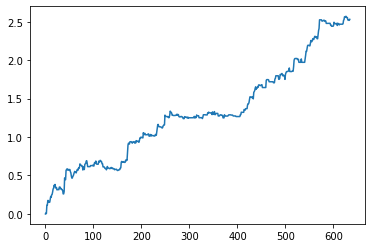

Stock Wise PNL Visualisation


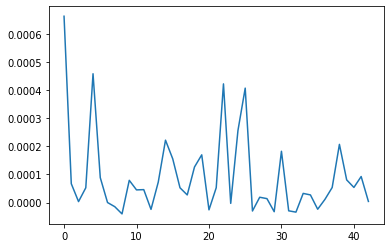

Time wise and Stock wise PNL heatmap


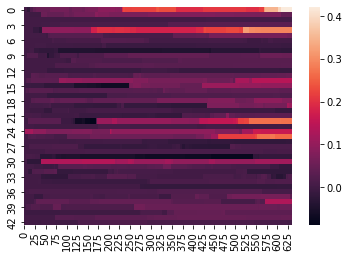

In [25]:
 ###################################
#4. Run a Backtest    from 10/18/2020 to 5/23/2023, max 5 trades per day 
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

Next, we run the backtest for the strategy 'lowvol2' for the time period 10/18/2019 to 5/23/2023, and let the maximal number of stocks to be traded on each day to be 5.

We notice that the cumulative PnL percentage of the portfolio had increased by 303% over the period 10/18/2019 to 5/23/2023, with Sharpe ratio of 4.48 and Sortino ratio of 7.78.

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (3.033406700218594, 4.48388307083419, 7.779020382517792, 0.5173807599029911)
Equity Curve(PNL on $1)


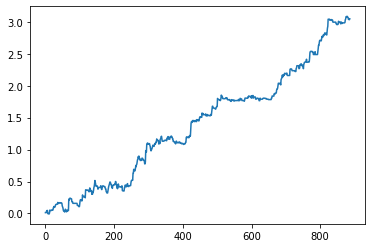

Stock Wise PNL Visualisation


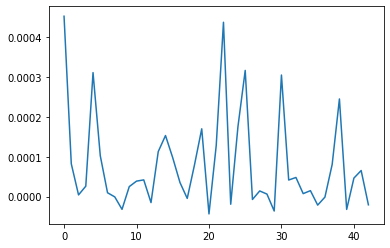

Time wise and Stock wise PNL heatmap


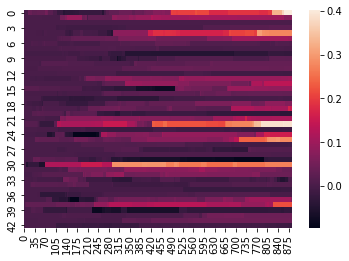

In [27]:
 ###################################
# Run a Backtest    from 10/18/2019 to 5/23/2023, max 5 trades per day 
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

Now we run the backtest for the strategy 'lowvol2' for the time period 10/18/2020 to 5/23/2023, and set the maximal number of stocks to be traded on each day to be 3.

We notice that the cumulative PnL percentage of the portfolio had increased by 263% over the period from 10/18/2020 to 5/23/2023, with Sharpe ratio of 4.6 and Sortino ratio of 8.57.

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (2.6343693787536244, 4.600303550896371, 8.567932156988242, 0.5261984392419174)
Equity Curve(PNL on $1)


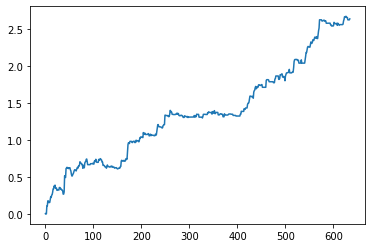

Stock Wise PNL Visualisation


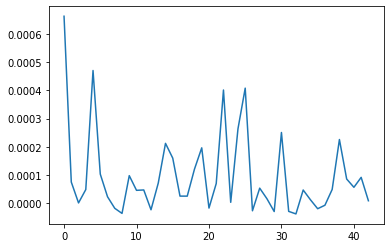

Time wise and Stock wise PNL heatmap


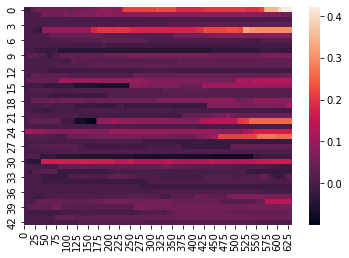

In [34]:
 ###################################
# Run a Backtest    from 10/18/2020 to 5/23/2023, max 3 trades per day
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

Now we run the backtest for the strategy 'lowvol2' for the time period 10/18/2019 to 5/23/2023, and set the maximal number of stocks to be traded on each day to be 3.

We notice that the cumulative PnL percentage of the portfolio had increased by 311% over the period 10/18/2019 to 5/23/2023, with Sharpe ratio of 4.45 and Sortino ratio of 7.76. To imporove the results, it is better to trade fewer stocks.

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (3.1118105378940157, 4.453686851254572, 7.762418305441416, 0.5165723524656427)
Equity Curve(PNL on $1)


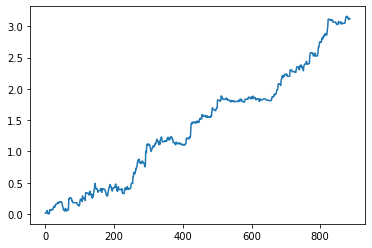

Stock Wise PNL Visualisation


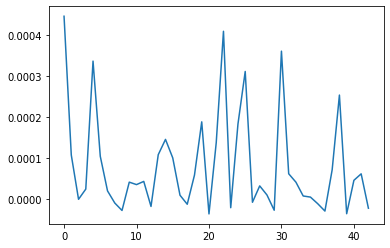

Time wise and Stock wise PNL heatmap


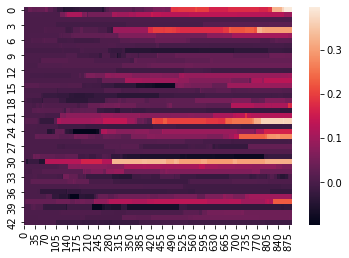

In [36]:
 ###################################
# Run a Backtest   from 10/18/2019 to 5/23/2023, max 3 trades per day
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

The strategy 'lowvol2' is parameter dependent and its performance improves significantly after the parameters are tuned. Ideally the 'parameter tuneup' should be performed every few weeks. If it is not, the strategy starts to show more oscillations. The strategy 'lowvol2' was last 'tuned' around '5/14/2023'. Here is the performance of the stategy without a 'tuneup' on 10/10/2023 about 5 months later than the last 'tuneup'. The strategy is expected to perform much better after a parameter 'tuneup'.

Here, we run the backtest for the strategy 'lowvol2' for the time period 10/18/2020 to 10/10/2023, and set the maximal number of stocks to be traded on each day to be 3.

We notice that the cumulative PnL percentage of the portfolio had increased by 264% over the period of 3 years, with Sharpe ratio of 4.42 and Sortino ratio of 7.95.

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (2.6384900141524006, 4.418321199587186, 7.947138290610787, 0.5241312741312741)
Equity Curve(PNL on $1)


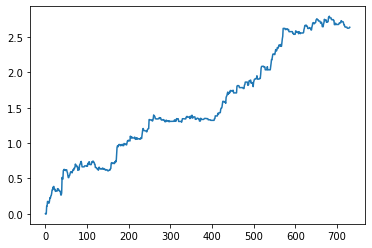

Stock Wise PNL Visualisation


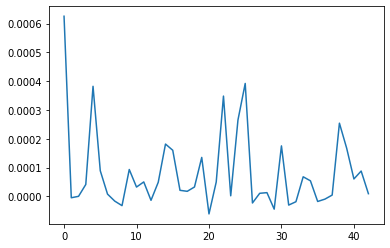

Time wise and Stock wise PNL heatmap


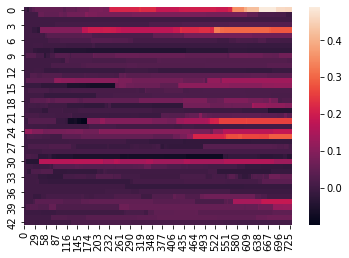

In [39]:
 ###################################
# Run a Backtest    from 10/18/2020 to 10/10/2023, max 3 trades per day
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

The strategy 'lowvol2' is parameter dependent and its performance improves significantly after the parameters are tuned. Ideally the 'parameter tuneup' should be performed every few weeks. If it is not, the strategy starts to show more oscillations. The strategy 'lowvol2' was last 'tuned' around '5/14/2023'. Here is the performance of the stategy without a 'tuneup' on 10/10/2023 about 5 months later, in this case for a 4 year history of stock prices. The strategy is expected to perform much better after a parameter 'tuneup'.

Here, we run the backtest for the strategy 'lowvol2' for the time period 10/18/2019 to 10/10/2023, and set the maximal number of stocks to be traded on each day to be 3.

We notice that the cumulative PnL percentage of the portfolio had increased by 312% over the period of 4 years, with Sharpe ratio of 4.34 and Sortino ratio of 7.43.

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (3.1159311732927915, 4.3356334579904106, 7.428538817738084, 0.5159883720930233)
Equity Curve(PNL on $1)


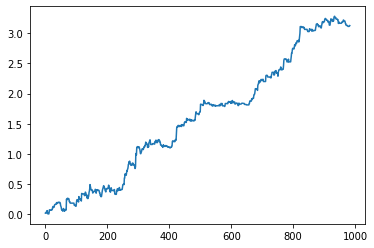

Stock Wise PNL Visualisation


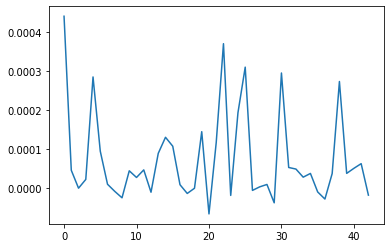

Time wise and Stock wise PNL heatmap


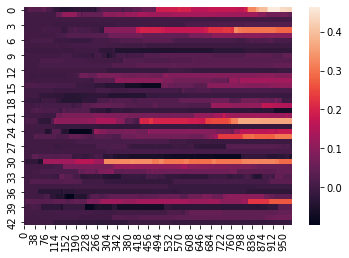

In [41]:
 ###################################
# Run a Backtest    from 10/18/2019 to 10/10/2023, max 3 trades per day
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

If we run the backtest on a different day (this is run on 10/20/2023, while the previous backtest results were run on 10/18/2023), but for the same endpoint 5/23/2023, the shape of the PnL percentage Equity Curve graph is the same, but the numerical answers are slightly different. This is possibly connected to a slightly different set of 43 stocks downloaded by the backtest program, a shorter time interval and stock price fluctuations.

Here we run again the backtest for the time interval 10/20/2019 to 5/23/2023, with the maximal number of 3 trades per day. We notice that the cumulative PnL percentage of the portfolio had increased by 295% over the period from 10/20/2019 to 5/23/2023, with Sharpe ratio of 4.22 and Sortino ratio of 7.33.

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (2.9523403879305343, 4.221060591010191, 7.328757017532717, 0.5141471301535974)
Equity Curve(PNL on $1)


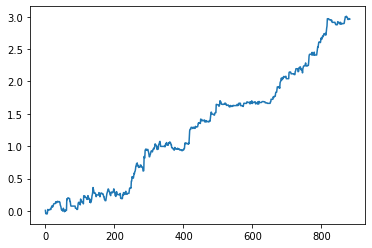

Stock Wise PNL Visualisation


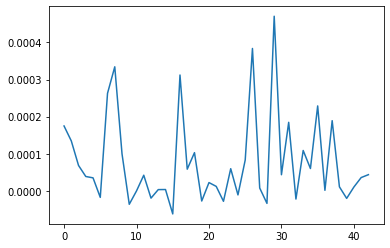

Time wise and Stock wise PNL heatmap


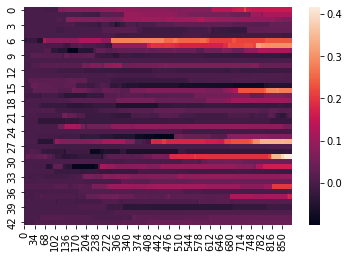

In [35]:
 ###################################
# Run a Backtest    from 10/20/2019 to 5/23/2023, max of 3 trades per day
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

If we run the backtest on a different day (this is run on 10/20/2023), but for the same endpoint 5/23/2023, the shape of the PnL percentage Equity Curve graph is the same, but the numerical answers are slightly different. 

Here we run the backtest for the time interval 10/20/2020 to 5/23/2023, with the maximal number of 3 trades per day. We notice that the cumulative PnL percentage of the portfolio had increased by 243% over the period from 10/20/2020 to 5/23/2023, with Sharpe ratio of 4.37 and Sortino ratio of 7.88.

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (2.432401127744492, 4.366751892514007, 7.87531902924857, 0.5239154616240267)
Equity Curve(PNL on $1)


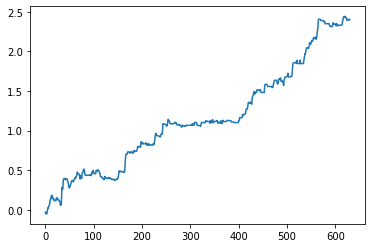

Stock Wise PNL Visualisation


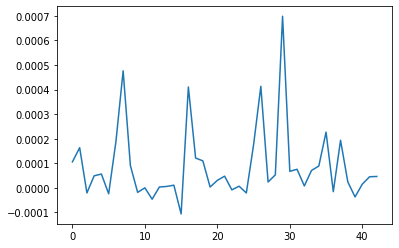

Time wise and Stock wise PNL heatmap


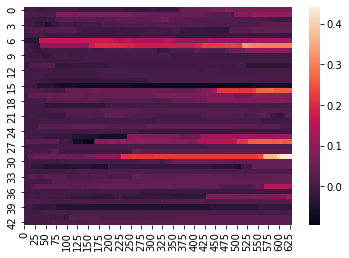

In [38]:
 ###################################
# Run a Backtest    from 10/20/2020 to 5/23/2023, max 3 trades per day
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

To see how the strategy does over the last half-year, we run the backtest for the strategy 'lowvol2' for the time period 10/20/2022 to 5/23/2023, and set the maximal number of stocks to be traded on each day to be 3.

We notice that the cumulative PnL percentage of the portfolio had increased by 68.5% over the last half-year, with Sharpe ratio of 2.98 and Sortino ratio of 5.45.

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (0.6846343333021462, 2.9767307673058494, 5.4534560462597454, 0.543010752688172)
Equity Curve(PNL on $1)


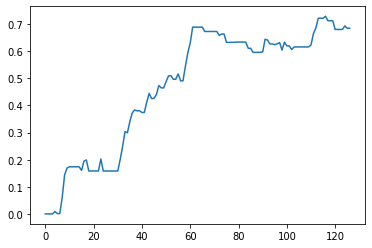

Stock Wise PNL Visualisation


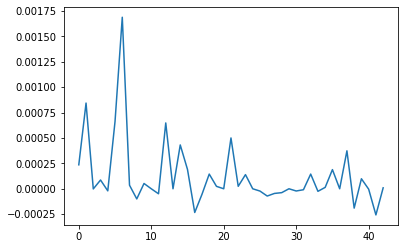

Time wise and Stock wise PNL heatmap


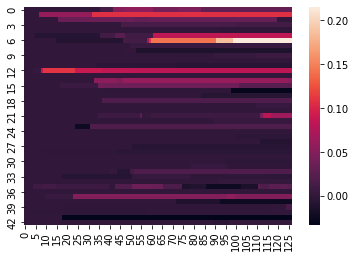

In [11]:
###################################
# Run a Backtest    from 10/20/2022 to 5/23/2023, max 3 trades per day
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

We can take a look at what happens if we trade only 1 stock per day (this is run on 10/20/2023).

Here we run again the backtest for the time interval 10/20/2019 to 5/23/2023, with the maximal number of 1 trade per day. We notice that the cumulative PnL percentage of the portfolio had increased by 302% over the period from 10/20/2019 to 5/23/2023, with Sharpe ratio of 3.41 and Sortino ratio of 5.72.

Therefore trading only 1 stock per day increases the risk in the strategy.

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (3.017520424020117, 3.4123723982736083, 5.717230360598608, 0.5092966855295069)
Equity Curve(PNL on $1)


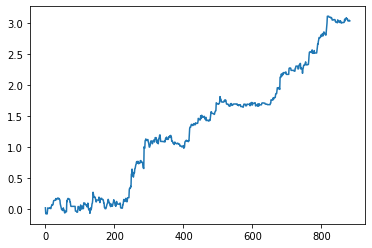

Stock Wise PNL Visualisation


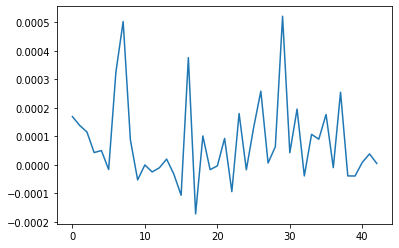

Time wise and Stock wise PNL heatmap


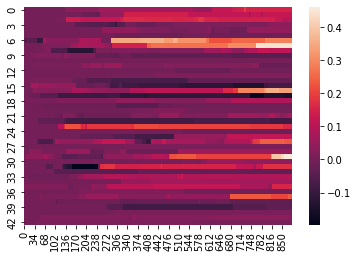

In [27]:
###################################
# Run a Backtest    from 10/20/2019 to 5/23/2023, max of 1 trade per day
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

Now we can try to trade only 2 stocks per day (this is run on 10/20/2023).

Here we run the backtest for the time interval 10/20/2019 to 5/23/2023, with the maximal number of 2 trades per day. We notice that the cumulative PnL percentage of the portfolio had increased by 305.5% over the period 10/20/2019 to 5/23/2023, with Sharpe ratio of 4.18 and Sortino ratio of 7.3.

Therefore trading only 2 stocks per day decreases the risk in the strategy significantly compared with trading 1 stock per day.

Notice that for all the backtests for stock history starting on 10/20/2019 ending on 5/23/2023, the basic shape of the PnL percentage Equity Curve graph is the same, but with the lower number of trades per day the graphs become 'noisier'. 

The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (3.0548719502212514, 4.182549875821655, 7.299661931647197, 0.5149555375909458)
Equity Curve(PNL on $1)


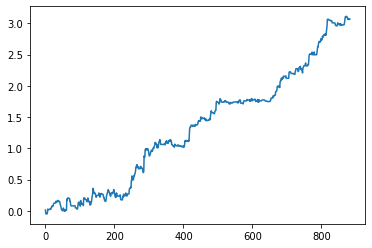

Stock Wise PNL Visualisation


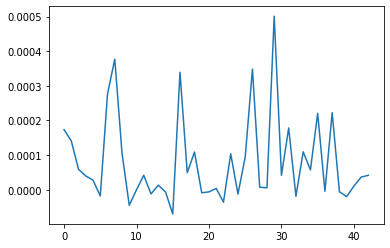

Time wise and Stock wise PNL heatmap


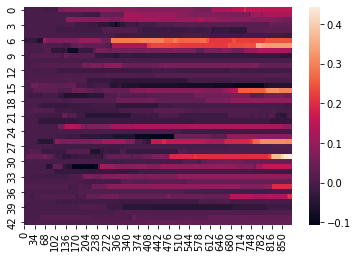

In [30]:
###################################
# Run a Backtest    from 10/20/2019 to 5/23/2023, max of 2 trades per day
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 

For comparison, we show again what happens if we trade max of 5 stocks per day (this is run on 10/20/2023).

Here we run the backtest for the time interval 10/20/2019 to 5/23/2023, with the maximal number of 5 trades per day. We notice that the cumulative PnL percentage of the portfolio had increased by 289% over the period from 10/20/2019 to 5/23/2023, with Sharpe ratio of 4.27 and Sortino ratio of 7.37.

Therefore trading the maximum of 5 stock per day decreases the risk in the strategy, compared to the lower number of trades per day.


The quantities are the returns, Sharpe, Sortino, Percentage of Winning Days
Returns, Sharpe, Sortino, Perc Winning Days (2.893720077484927, 4.273709994764896, 7.3724460098202735, 0.5125303152789006)
Equity Curve(PNL on $1)


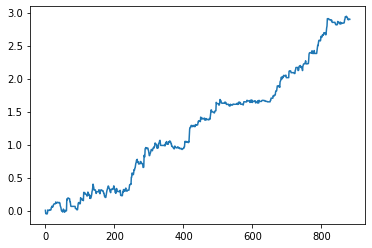

Stock Wise PNL Visualisation


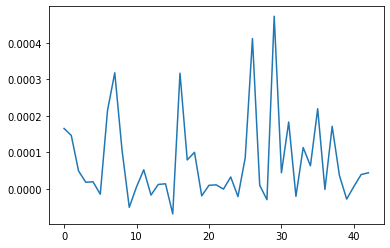

Time wise and Stock wise PNL heatmap


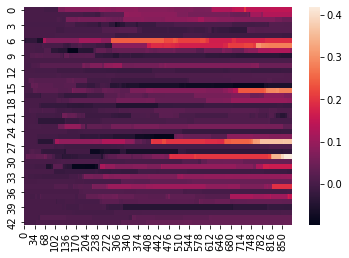

In [7]:
###################################
# Run a Backtest    from 10/20/2019 to 5/23/2023, max 5 trades per day  
params={'strategy_id':'lowvol2'}
display_backtest(lrs, prediction_function, params=params) 